In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import scipy.io

import gc
import matplotlib.pyplot as plt
import time

from scipy.misc import imread, imresize, imsave, fromimage, toimage
from PIL import Image

from tensorflow.python.layers import utils

from keras import optimizers
from keras.models import Model
from keras.layers import Input, ZeroPadding2D,merge, Lambda, concatenate
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D,Deconvolution2D 
from keras.layers.convolutional import Conv2D,UpSampling2D,Cropping2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization

from keras.layers.merge import add, concatenate
from keras.layers.core import Activation
from keras.initializers import RandomNormal

from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import Regularizer

from keras import regularizers
from keras import initializers
from keras import constraints

from keras import backend as K
from keras.preprocessing import image
from keras.engine.topology import Layer
from keras.engine import InputSpec

from keras.applications.vgg19 import preprocess_input
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16

import warnings
warnings.filterwarnings('ignore')

c:\users\hp\anaconda3\envs\neural-style\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
IMG_HEIGHT = 256
IMG_WIDTH = 256
tv_weight = 1e-6

test_style_image = 'images/style/starry_night.jpg'
test_content_image = 'images/content/101.jpg'
#K.set_learning_phase(1)

In [3]:
def load_image(image_path, IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT):
    mode = "RGB"
    img = imread(image_path, mode=mode)

    img = imresize(img,(IMG_WIDTH, IMG_HEIGHT)).astype('float32')

    # 這個keras內建函式可以幫我們做到上面的轉換
    #img = preprocess_input(img)
    
    if K.image_dim_ordering() == "th":
        img = img.transpose((2, 0, 1)).astype('float32')

    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return img

def preprocess_sn_image(img):
    # 這個keras內建函式可以幫我們做到上面的轉換
    img /= 255.
    return img

def preprocess_image(image_path, IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT):
    mode = "RGB"
    img = imread(image_path, mode=mode)

    img = imresize(img,(IMG_WIDTH, IMG_HEIGHT)).astype('float32')

    # 這個keras內建函式可以幫我們做到上面的轉換
    img = preprocess_input(img)
    
    if K.image_dim_ordering() == "th":
        img = img.transpose((2, 0, 1)).astype('float32')

    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return img

def deprocess_image(x, IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT):
    if K.image_dim_ordering() == "th":
        x = x.reshape((3, IMG_WIDTH, IMG_HEIGHT))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((IMG_WIDTH, IMG_HEIGHT, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    
    # BGR -> RGB
    x = x[:, :, ::-1]

    # 將陣列的值的範圍縮回 0~255，因為處理的結果有可能出現超過這個範圍的數字
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def get_ratio(image):
    img = Image.fromarray(image).convert('RGB')
    img_WIDTH, img_HEIGHT = img.size
    aspect_ratio = float(img_HEIGHT) / img_WIDTH
    return aspect_ratio


def show(x, IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT, save=False, name='', iterate=0):
    # 將張量轉回圖片的後處理
    img = deprocess_image(x.copy())
    
    # 取得原圖比例
    aspect_ratio = get_ratio(img)  
    img_ht = int(IMG_WIDTH * aspect_ratio)
    #print("Rescaling Image to (%d, %d)" % (IMG_WIDTH, img_ht))
    img = imresize(img, (IMG_WIDTH, img_ht), interp='bilinear')
    im = toimage(img)
    if save:
        filename = 'output/%s_%d.jpg' % (name, iterate)
        imsave(filename, im)
    else:
        plt.imshow(im)
    
def show_without_deprocess(x, IMG_WIDTH=IMG_WIDTH, IMG_HEIGHT=IMG_HEIGHT, save=False, name='', iterate=0):

    x = x.reshape((IMG_WIDTH, IMG_HEIGHT, 3))
    img = np.clip(x, 0, 255).astype('uint8')
    
    aspect_ratio = get_ratio(img)  
    img_ht = int(IMG_WIDTH * aspect_ratio)
    #print("Rescaling Image to (%d, %d)" % (IMG_WIDTH, img_ht))
    img = imresize(img, (IMG_WIDTH, img_ht), interp='bilinear')
    im = toimage(img)
    if save:
        filename = 'output/%s_%d.jpg' % (name, iterate)
        imsave(filename, im)
    else:
        plt.imshow(im)

In [4]:
content_image = load_image(test_content_image)
style_image = load_image(test_style_image)

(1, 256, 256, 3)
(1, 256, 256, 3)


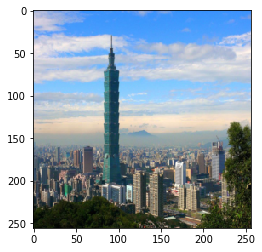

In [5]:
show_without_deprocess(content_image, save=False)

In [6]:
# =================================================================
# input_1 (InputLayer)         (None, None, None, 3)     0         
# _________________________________________________________________
# block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
# _________________________________________________________________
# block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
# _________________________________________________________________
# block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
# _________________________________________________________________
# block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
# _________________________________________________________________
# block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
# _________________________________________________________________
# block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
# _________________________________________________________________
# block3_conv1 (Conv2D)        (None, None, None, 256)   295168    
# _________________________________________________________________
# block3_conv2 (Conv2D)        (None, None, None, 256)   590080    
# _________________________________________________________________
# block3_conv3 (Conv2D)        (None, None, None, 256)   590080    
# _________________________________________________________________
# block3_conv4 (Conv2D)        (None, None, None, 256)   590080    
# _________________________________________________________________
# block3_pool (MaxPooling2D)   (None, None, None, 256)   0         
# _________________________________________________________________
# block4_conv1 (Conv2D)        (None, None, None, 512)   1180160   
# _________________________________________________________________
# block4_conv2 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block4_conv3 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block4_conv4 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block4_pool (MaxPooling2D)   (None, None, None, 512)   0         
# _________________________________________________________________
# block5_conv1 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block5_conv2 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block5_conv3 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block5_conv4 (Conv2D)        (None, None, None, 512)   2359808   
# _________________________________________________________________
# block5_pool (MaxPooling2D)   (None, None, None, 512)   0         
# =================================================================

In [7]:
def build_encode_net(input_shape):
    
    #vgg = VGG19(include_top=False, input_tensor=input_tensor)
    vgg = VGG19(include_top=False, input_shape=input_shape)
    
    encode_layer = Model(vgg.input, vgg.layers[7].output)
    
    for layer in encode_layer.layers[:]:
        layer.trainable = False
    
    encode_layer.compile(optimizer='adam', loss='mse')
    return encode_layer

In [9]:
class InstanceNormalization(Layer):
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if (self.axis is not None):
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [8]:
class AdaptiveInstanceNormalize(Layer):
    def __init__(self, **kwargs):
        super(AdaptiveInstanceNormalize, self).__init__(**kwargs)
        self.epsilon = 1e-5
        self.alpha = 0.8
            

    def call(self, x, mask=None):
        style_mean, style_variance = tf.nn.moments(style_features, [1,2], keep_dims=True)
        content_mean, content_variance = tf.nn.moments(content_features, [1,2], keep_dims=True)
        
        normalized_content_features = tf.nn.batch_normalization(content_features, content_mean,
                                                            content_variance, style_mean, 
                                                            tf.sqrt(style_variance), self.epsilon)
        
        normalized_content_features = self.alpha * normalized_content_features + (1 - self.alpha) * content_features
        return normalized_content_features
                                                 
    def compute_output_shape(self,input_shape):
        return input_shape

class InstanceNormalize(Layer):
    def __init__(self, **kwargs):
        super(InstanceNormalize, self).__init__(**kwargs)
        self.epsilon = 1e-3
            

    def call(self, x, mask=None):
        mean, var = tf.nn.moments(x, [1, 2], keep_dims=True)
        return tf.div(tf.subtract(x, mean), tf.sqrt(tf.add(var, self.epsilon)))

                                                 
    def compute_output_shape(self,input_shape):
        return input_shape
    
class VGGNormalize(Layer):
    '''
    Custom layer to subtract the outputs of previous layer by 120,
    to normalize the inputs to the VGG network.
    '''

    def __init__(self, **kwargs):
        super(VGGNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        # No exact substitute for set_subtensor in tensorflow
        # So we subtract an approximate value       
        
        # 'RGB'->'BGR'
        x = preprocess_input(x)
        return x
   

    def compute_output_shape(self,input_shape):
        return input_shape
    
class TanhNormalize(Layer):
    '''
    Custom layer to subtract the outputs of previous layer by 120,
    to normalize the inputs to the VGG network.
    '''

    def __init__(self, **kwargs):
        super(TanhNormalize, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        # No exact substitute for set_subtensor in tensorflow
        # So we subtract an approximate value       
        
        # 'RGB'->'BGR'
        x = (x + 1) * (255.0 / 2)
        return x
   

    def compute_output_shape(self,input_shape):
        return input_shape

In [10]:
def conv_in_relu(nb_filter, nb_row, nb_col,stride):   
    def conv_func(x):
        x = Conv2D(nb_filter, (nb_row, nb_col), strides=stride , padding='same')(x)
        x = InstanceNormalization()(x)
        x = Activation("relu")(x)
        return x
    return conv_func

def res_conv(nb_filter, nb_row, nb_col,stride=(1,1)):
    def _res_func(x):
        #identity = Cropping2D(cropping=((2,2),(2,2)))(x)

        a = Conv2D(nb_filter, (nb_row, nb_col), strides=stride, padding='same')(x)
        a = InstanceNormalize()(a)
        #a = LeakyReLU(0.2)(a)
        a = Activation("relu")(a)
        a = Conv2D(nb_filter, (nb_row, nb_col), strides=stride, padding='same')(a)
        y = InstanceNormalize()(a)

        return  add([x, y])

    return _res_func

def dconv_bn_nolinear(nb_filter, nb_row, nb_col,stride=(2,2),activation="relu"):
    def _dconv_bn(x):
        x = UnPooling2D(size=stride)(x)
        x = ReflectionPadding2D(padding=stride)(x)
        x = Conv2D(nb_filter, (nb_row, nb_col), padding='valid')(x)
        x = InstanceNormalization()(x)
        x = Activation(activation)(x)
        return x
    return _dconv_bn


def add_total_variation_loss(transform_output_layer,weight):
    # Total Variation Regularization
    layer = transform_output_layer  # Output layer
    tv_regularizer = TVRegularizer(weight)(layer)
    layer.add_loss(tv_regularizer)
    
    
class TVRegularizer(Regularizer):
    """ Enforces smoothness in image output. """

    def __init__(self, weight=1.0):
        self.weight = weight
        self.uses_learning_phase = False
        super(TVRegularizer, self).__init__()

    def __call__(self, x):
        assert K.ndim(x.output) == 4
        x_out = x.output
        
        shape = K.shape(x_out)
        img_width, img_height,channel = (shape[1],shape[2], shape[3])
        size = img_width * img_height * channel 
        if K.image_dim_ordering() == 'th':
            a = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, 1:, :img_height - 1])
            b = K.square(x_out[:, :, :img_width - 1, :img_height - 1] - x_out[:, :, :img_width - 1, 1:])
        else:
            a = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, 1:, :img_height - 1, :])
            b = K.square(x_out[:, :img_width - 1, :img_height - 1, :] - x_out[:, :img_width - 1, 1:, :])
        loss = self.weight * K.sum(K.pow(a + b, 1.25)) 
        return loss


In [11]:
def build_inverse_net(input_tensor):
    i = Input(tensor=input_tensor)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(i)
    x = UpSampling2D()(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    y = conv_in_relu(3, 3, 3, stride=(1,1))(x)
    
    model = Model(inputs=i, outputs=y)
    return model

In [12]:
def wct_style_swap(x, alpha=0.8, patch_size=3, stride=1, eps=1e-8):
    '''Modified Whiten-Color Transform that performs style swap on whitened content/style encodings before coloring
       Assume that content/style encodings have shape 1xHxWxC
    '''
    
    content = K.expand_dims(x[0], 0)
    style = K.expand_dims(x[1], 0)
    
    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(tf.shape(content_t))
    Cs, Hs, Ws = tf.unstack(tf.shape(style_t))

    # CxHxW -> CxH*W
    content_flat = tf.reshape(content_t, (Cc, Hc*Wc))
    style_flat = tf.reshape(style_t, (Cs, Hs*Ws))

    # Content covariance
    mc = tf.reduce_mean(content_flat, axis=1, keep_dims=True)
    fc = content_flat - mc
    fcfc = tf.matmul(fc, fc, transpose_b=True) / (tf.cast(Hc*Wc, tf.float32) - 1.) + tf.eye(Cc)*eps

    # Style covariance
    ms = tf.reduce_mean(style_flat, axis=1, keep_dims=True)
    fs = style_flat - ms
    fsfs = tf.matmul(fs, fs, transpose_b=True) / (tf.cast(Hs*Ws, tf.float32) - 1.) + tf.eye(Cs)*eps

    # tf.svd is slower on GPU, see https://github.com/tensorflow/tensorflow/issues/13603
    with tf.device('/cpu:0'):  
        Sc, Uc, _ = tf.svd(fcfc)
        Ss, Us, _ = tf.svd(fsfs)

    ## Uncomment to perform SVD for content/style with np in one call
    ## This is slower than CPU tf.svd but won't segfault for ill-conditioned matrices
    # @jit
    # def np_svd(content, style):
    #     '''tf.py_func helper to run SVD with NumPy for content/style cov tensors'''
    #     Uc, Sc, _ = np.linalg.svd(content)
    #     Us, Ss, _ = np.linalg.svd(style)
    #     return Uc, Sc, Us, Ss
    # Uc, Sc, Us, Ss = tf.py_func(np_svd, [fcfc, fsfs], [tf.float32, tf.float32, tf.float32, tf.float32])
    
    k_c = tf.reduce_sum(tf.cast(tf.greater(Sc, 1e-5), tf.int32))
    k_s = tf.reduce_sum(tf.cast(tf.greater(Ss, 1e-5), tf.int32))

    ### Whiten content
    Dc = tf.diag(tf.pow(Sc[:k_c], -0.5))

    fc_hat = tf.matmul(tf.matmul(tf.matmul(Uc[:,:k_c], Dc), Uc[:,:k_c], transpose_b=True), fc)

    # Reshape before passing to style swap, CxH*W -> 1xHxWxC
    whiten_content = tf.expand_dims(tf.transpose(tf.reshape(fc_hat, [Cc,Hc,Wc]), [1,2,0]), 0)

    ### Whiten style before swapping
    Ds = tf.diag(tf.pow(Ss[:k_s], -0.5))
    whiten_style = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds), Us[:,:k_s], transpose_b=True), fs)
    # Reshape before passing to style swap, CxH*W -> 1xHxWxC
    whiten_style = tf.expand_dims(tf.transpose(tf.reshape(whiten_style, [Cs,Hs,Ws]), [1,2,0]), 0)

    ### Style swap whitened encodings
    #ss_feature = ori_style_swap_layer(whiten_content, whiten_style, patch_size, stride)
    
    ###############################################
    nC = tf.shape(whiten_style)[-1]  # Num channels of input content feature and style-swapped output

    ### Extract patches from style image that will be used for conv/deconv layers
    style_patches = tf.extract_image_patches(whiten_style, [1,patch_size,patch_size,1], [1,stride,stride,1], [1,1,1,1], 'VALID')
    before_reshape = tf.shape(style_patches)  # NxRowsxColsxPatch_size*Patch_size*nC
    style_patches = tf.reshape(style_patches, [before_reshape[1]*before_reshape[2],patch_size,patch_size,nC])
    style_patches = tf.transpose(style_patches, [1,2,3,0])  # Patch_sizexPatch_sizexIn_CxOut_c

    # Normalize each style patch
    style_patches_norm = tf.nn.l2_normalize(style_patches, dim=3)

    # Compute cross-correlation/nearest neighbors of patches by using style patches as conv filters
    ss_enc = tf.nn.conv2d(whiten_content,
                          style_patches_norm,
                          [1,stride,stride,1],
                          'VALID')

    # For each spatial position find index of max along channel/patch dim  
    ss_argmax = tf.argmax(ss_enc, axis=3)
    encC = tf.shape(ss_enc)[-1]  # Num channels in intermediate conv output, same as # of patches
    
    # One-hot encode argmax with same size as ss_enc, with 1's in max channel idx for each spatial pos
    ss_oh = tf.one_hot(ss_argmax, encC, 1., 0., 3)

    # Calc size of transposed conv out
    deconv_out_H = utils.deconv_output_length(tf.shape(ss_oh)[1], patch_size, 'valid', stride)
    deconv_out_W = utils.deconv_output_length(tf.shape(ss_oh)[2], patch_size, 'valid', stride)
    deconv_out_shape = tf.stack([1,deconv_out_H,deconv_out_W,nC])

    # Deconv back to original content size with highest matching (unnormalized) style patch swapped in for each content patch
    ss_dec = tf.nn.conv2d_transpose(ss_oh,
                                    style_patches,
                                    deconv_out_shape,
                                    [1,stride,stride,1],
                                    'VALID')

    ### Interpolate to average overlapping patch locations
    ss_oh_sum = tf.reduce_sum(ss_oh, axis=3, keep_dims=True)

    filter_ones = tf.ones([patch_size,patch_size,1,1], dtype=tf.float32)
    
    deconv_out_shape = tf.stack([1,deconv_out_H,deconv_out_W,1])  # Same spatial size as ss_dec with 1 channel

    counting = tf.nn.conv2d_transpose(ss_oh_sum,
                                         filter_ones,
                                         deconv_out_shape,
                                         [1,stride,stride,1],
                                         'VALID')

    counting = tf.tile(counting, [1,1,1,nC])  # Repeat along channel dim to make same size as ss_dec

    ss_feature = tf.divide(ss_dec, counting)
    ###############################################
    
    # HxWxC -> CxH*W
    ss_feature = tf.transpose(tf.reshape(ss_feature, [Hc*Wc,Cc]), [1,0])

    ### Color style-swapped encoding with style 
    Ds_sq = tf.diag(tf.pow(Ss[:k_s], 0.5))
    fcs_hat = tf.matmul(tf.matmul(tf.matmul(Us[:,:k_s], Ds_sq), Us[:,:k_s], transpose_b=True), ss_feature)
    fcs_hat = fcs_hat + ms

    ### Blend style-swapped & colored encoding with original content encoding
    blended = alpha * fcs_hat + (1 - alpha) * (fc + mc)
    # CxH*W -> CxHxW
    blended = tf.reshape(blended, (Cc,Hc,Wc))
    # CxHxW -> 1xHxWxC
    blended = tf.expand_dims(tf.transpose(blended, (1,2,0)), 0)

    return blended


In [13]:
def style_swap_layer(x, patch_size=3, stride=1):
    '''Efficiently swap content feature patches with nearest-neighbor style patches
       Original paper: https://arxiv.org/abs/1612.04337
       Adapted from: https://github.com/rtqichen/style-swap/blob/master/lib/NonparametricPatchAutoencoderFactory.lua
    '''
    content = K.expand_dims(x[0], 0)
    style = K.expand_dims(x[1], 0)
        
        
    nC = style.shape[-1]  # Num channels of input content feature and style-swapped output

    content_t = tf.transpose(tf.squeeze(content), (2, 0, 1))
    style_t = tf.transpose(tf.squeeze(style), (2, 0, 1))

    Cc, Hc, Wc = tf.unstack(content_t.shape)
    Cs, Hs, Ws = tf.unstack(style_t.shape)


    ### Extract patches from style image that will be used for conv/deconv layers
    style_patches = tf.extract_image_patches(style, [1, patch_size, patch_size, 1], 
                                                 [1, stride, stride, 1], [1, 1, 1, 1], 'VALID')

    before_reshape = style_patches.shape  # NxRowsxColsxPatch_size*Patch_size*nC

    style_patches = tf.reshape(style_patches, [before_reshape[1] * before_reshape[2], patch_size, patch_size, nC])

    style_patches = tf.transpose(style_patches, [1, 2, 3, 0])  # Patch_size x Patch_size x In_C x Out_c

    # Normalize each style patch
    style_patches_norm = tf.nn.l2_normalize(style_patches, dim=3)

    # Compute cross-correlation/nearest neighbors of patches by using style patches as conv filters
    ss_enc = tf.nn.conv2d(content,
                              style_patches_norm,
                              [1, stride, stride, 1],
                              'VALID')

    # For each spatial position find index of max along channel/patch dim  
    ss_argmax = tf.argmax(ss_enc, axis=3)
    encC = ss_enc.shape[-1]  # Num channels in intermediate conv output, same as # of patches

    # One-hot encode argmax with same size as ss_enc, with 1's in max channel idx for each spatial pos
    ss_oh = tf.one_hot(ss_argmax, encC, 1., 0., 3)

    # Calc size of transposed conv out
    deconv_out_H = utils.deconv_output_length(ss_oh.shape[1], patch_size, 'valid', stride)
    deconv_out_W = utils.deconv_output_length(ss_oh.shape[2], patch_size, 'valid', stride)
    deconv_out_shape = tf.stack([1, deconv_out_H, deconv_out_W, nC])


    # Deconv back to original content size with highest matching (unnormalized) style patch swapped in for each content patch
    ss_dec = tf.nn.conv2d_transpose(ss_oh,
                                        style_patches,
                                        deconv_out_shape,
                                        [1, stride, stride, 1],
                                        'VALID')

    ### Interpolate to average overlapping patch locations
    ss_oh_sum = tf.reduce_sum(ss_oh, axis=3, keep_dims=True)

    filter_ones = tf.ones([patch_size, patch_size, 1, 1], dtype=tf.float32)

    deconv_out_shape = tf.stack([1, deconv_out_H, deconv_out_W, 1])  # Same spatial size as ss_dec with 1 channel

    counting = tf.nn.conv2d_transpose(ss_oh_sum,
                                             filter_ones,
                                             deconv_out_shape,
                                             [1, stride, stride,1],
                                             'VALID')

    counting = tf.tile(counting, [1, 1, 1, nC])  # Repeat along channel dim to make same size as ss_dec

    interpolated_dec = tf.divide(ss_dec, counting)
        
    return interpolated_dec

In [14]:
def swap_op(content_feature, style_feature):
    height = tf.shape(content_feature)[1]
    width = tf.shape(content_feature)[2]
    print(style_feature)
    normalized_filters = tf.nn.l2_normalize(style_feature, dim=(0, 1, 2))

    """ change the strides to see difference"""
    similarity = tf.nn.conv2d(content_feature, normalized_filters, strides=[1, 1, 1, 1], padding="VALID")

    arg_max_filter = tf.argmax(similarity, axis=-1)
    one_hot_filter = tf.one_hot(arg_max_filter, depth=similarity.get_shape()[-1].value)

    swap = tf.nn.conv2d_transpose(one_hot_filter, style_feature, output_shape=tf.shape(content_feature),
                                      strides=[1, 1, 1, 1], padding="VALID")
    return swap / 9.0

def benben_swap(x, cell_size=3, stride=1):
    content_feature = K.expand_dims(x[0], 0)
    style_feature = K.expand_dims(x[1], 0)
    
    style_amount = style_feature.get_shape()[0].value
    
    rows = tf.split(style_feature, num_or_size_splits=list(
            [cell_size] * (style_feature.get_shape()[1].value // cell_size) + [style_feature.get_shape()[1].value % cell_size]), axis=1)[:-1]
    cells = [tf.split(row, num_or_size_splits=list(
            [cell_size] * (style_feature.get_shape()[2].value // cell_size) + [style_feature.get_shape()[2].value % cell_size]), axis=2)[:-1]
                 for row in rows]

    stacked_cells = [tf.stack(row_cell, axis=4) for row_cell in cells]
    filters = tf.concat(stacked_cells, axis=-1)
    swaped_list = []
    for style_filter in tf.unstack(filters, axis=0, num=style_amount):
        swaped_list.append(swap_op(content_feature, style_filter))

    return tf.concat(swaped_list, axis=0)

In [15]:
def build_encode_net_with_swap_3_1(input_shape):
    
    content_input = Input(shape=input_shape, name='content_input')
    style_input = Input(shape=input_shape, name='style_input')
    x = concatenate([content_input, style_input], axis=0)
    
    vgg = VGG19(include_top=False, input_tensor=x)
    
    swapped = Lambda(style_swap_layer, output_shape=(64, 64, 256))(vgg.layers[-15].output)
    
    encode_layer = Model([content_input, style_input], swapped)
    
    for layer in encode_layer.layers[:]:
        layer.trainable = False
    
    encode_layer.compile(optimizer='adam', loss='mse')
    return encode_layer

def build_encode_net_vgg16_3_1(input_shape):
    
    content_input = Input(shape=input_shape, name='content_input')
    style_input = Input(shape=input_shape, name='style_input')
    x = concatenate([content_input, style_input], axis=0)
    
    vgg = VGG16(include_top=False, input_tensor=x)
    
    swapped = Lambda(style_swap_layer, output_shape=(64, 64, 256))(vgg.layers[-12].output)
    
    encode_layer = Model([content_input, style_input], swapped)
    
    for layer in encode_layer.layers[:]:
        layer.trainable = False
    
    encode_layer.compile(optimizer='adam', loss='mse')
    return encode_layer

def build_encode_net_with_swap_3_3(input_shape):
    
    content_input = Input(shape=input_shape, name='content_input')
    style_input = Input(shape=input_shape, name='style_input')
    x = concatenate([content_input, style_input], axis=0)
    
    vgg = VGG19(include_top=False, input_tensor=x)
    
    swapped = Lambda(wct_style_swap, output_shape=(64, 64, 256))(vgg.layers[-13].output)
    
    encode_layer = Model([content_input, style_input], swapped)
    
    for layer in encode_layer.layers[:]:
        layer.trainable = False
    
    encode_layer.compile(optimizer='adam', loss='mse')
    return encode_layer

In [16]:
def InverseNet_4(feature):
    ## feature = shape of content concatenate with style
    
    content_input = Input(shape=feature, name='content_input')
    style_input = Input(shape=feature, name='style_input')
    x = concatenate([content_input, style_input], axis=0)
    
    x = Lambda(wct_style_swap, output_shape=(64, 64, 256))(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    inverse_net_output = Conv2D(3, (3, 3), padding='same', name='inverse_net_output')(x)
    
    # Use vgg again to train inverse net
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='block1_conv1')(inverse_net_output)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    vgg_out = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
              
    model = Model(inputs=[content_input, style_input], outputs=vgg_out)
   
    add_total_variation_loss(model.layers[-8], tv_weight)
      
    return model


In [17]:
def InverseNet_5(feature):
    ## feature = shape of content concatenate with style
    
    swapped_input = Input(shape=feature, name='swapped_input')
    
    x = conv_in_relu(128, 3, 3, stride=(1,1))(swapped_input)
    x = UpSampling2D()(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    inverse_net_output = Conv2D(3, (3, 3), padding='same', name='inverse_net_output')(x)
    
    #x = VGGNormalize()(inverse_net_output)
    # Use vgg again to train inverse net
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='block1_conv1')(inverse_net_output)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    vgg_out = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
              
    model = Model(inputs=[swapped_input], outputs=vgg_out)
   
    add_total_variation_loss(model.layers[-8], tv_weight)
      
    return model

def InverseNet_3_1(feature):
    ## feature = shape of content concatenate with style
    
    swapped_input = Input(shape=feature, name='swapped_input')
    
    x = conv_in_relu(256, 3, 3, stride=(1,1))(swapped_input)
    x = UpSampling2D()(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    
    inverse_net_output = Conv2D(3, (3, 3), padding='same', name='inverse_net_output')(x)
    
    x = VGGNormalize()(inverse_net_output)
    # Use vgg again to train inverse net
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='block1_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    vgg_out = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
              
    model = Model(inputs=[swapped_input], outputs=vgg_out)
   
    add_total_variation_loss(model.layers[-9], tv_weight)
      
    return model

def InverseNet_3_3(feature):
    ## feature = shape of content concatenate with style
    
    swapped_input = Input(shape=feature, name='swapped_input')
    
    x = conv_in_relu(256, 3, 3, stride=(1,1))(swapped_input)
    x = conv_in_relu(256, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(256, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(256, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    
    inverse_net_output = Conv2D(3, (3, 3), padding='same', name='inverse_net_output')(x)
    
    #x = VGGNormalize()(inverse_net_output)
    # Use vgg again to train inverse net
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='block1_conv1')(inverse_net_output)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
    vgg_out = Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)

              
    model = Model(inputs=[swapped_input], outputs=vgg_out)
   
    add_total_variation_loss(model.layers[-10], tv_weight)
      
    return model

def InverseNet_3_3_res(feature):
    ## feature = shape of content concatenate with style
    
    swapped_input = Input(shape=feature, name='swapped_input')
    
    x = conv_in_relu(256, 3, 3, stride=(1,1))(swapped_input)
    x = res_conv(256, 3, 3, stride=(1,1))(x)
    x = res_conv(256, 5, 5, stride=(1,1))(x)
    x = res_conv(256, 7, 7, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(128, 5, 5, stride=(1,1))(x)
    #x = conv_in_relu(128, 3, 3, stride=(1,1))(x)
    x = UpSampling2D()(x)
    x = conv_in_relu(64, 5, 5, stride=(1,1))(x)
    x = conv_in_relu(64, 3, 3, stride=(1,1))(x)
    
    inverse_net_output = Conv2D(3, (3, 3), padding='same', name='inverse_net_output',activation="tanh")(x)
    
    x = TanhNormalize()(inverse_net_output)
    x = VGGNormalize()(x)
    # Use vgg again to train inverse net
    x = Conv2D(64, (3, 3),activation='relu', padding='same', name='block1_conv1')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
    x = Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv2')(x)
    vgg_out = Conv2D(256, (3, 3),activation='relu',padding='same',name='block3_conv3')(x)

              
    model = Model(inputs=[swapped_input], outputs=vgg_out)
   
    add_total_variation_loss(model.layers[-11], tv_weight)
      
    return model

In [18]:
datagen = image.ImageDataGenerator(preprocessing_function=preprocess_input)
#preprocessing_function=preprocess_input
epoch= 80000
batch_size=1

content_image_path="E:/cocodataset/train2014"
style_image_path="E:/paintdata"


content_gen = datagen.flow_from_directory(content_image_path,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=batch_size,
                                            class_mode=None)
    
style_gen = datagen.flow_from_directory(style_image_path,
                                            target_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=batch_size,
                                            class_mode=None)

Found 82783 images belonging to 1 classes.
Found 79436 images belonging to 1 classes.


In [19]:
K.set_learning_phase(1)

    
#content_placeholder = K.placeholder((1, IMG_HEIGHT, IMG_WIDTH, 3))
#style_placeholder = K.placeholder((1, IMG_HEIGHT, IMG_WIDTH, 3))
#input_tensor = K.concatenate([content_placeholder, style_placeholder], axis=0)   
    
# VGG feature extract
encode_net = build_encode_net_with_swap_3_1((IMG_HEIGHT, IMG_WIDTH, 3))


In [20]:
encode_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
content_input (InputLayer)      (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
style_input (InputLayer)        (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 256, 256, 3)  0           content_input[0][0]              
                                                                 style_input[0][0]                
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        concatenate_1[0][0]              
__________

In [21]:

#K.set_learning_phase(1)

In [22]:
print("Style swap")
# Style swap  
inverse_net = InverseNet_3_1((64 ,64 ,256))
    
for layer in inverse_net.layers[-7:]:
    layer.trainable = False

inverse_net.summary()

inverse_net.load_weights("C:/Users/HP/.keras/models/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5", by_name=True)
#inverse_net.load_weights("C:/Users/HP/.keras/models/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5", by_name=True)



Style swap
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
swapped_input (InputLayer)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 256)       2         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     295040    
_________________________________________________________________
instance_normalization_2 (In (None, 128, 128, 128)     2         

In [23]:
optimizer=optimizers.adam(lr=1e-3)
inverse_net.compile(optimizer=optimizer, loss='mean_squared_error')

In [24]:
output_image_func = K.function([inverse_net.input], [inverse_net.layers[-9].output])

In [25]:
test_content = encode_net.predict([content_image,style_image])

In [26]:
test_content.shape

(1, 64, 64, 256)

In [27]:
inverse_net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
swapped_input (InputLayer)   (None, 64, 64, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 256)       590080    
_________________________________________________________________
instance_normalization_1 (In (None, 64, 64, 256)       2         
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 256)       0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 128, 128, 256)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     295040    
_________________________________________________________________
instance_normalization_2 (In (None, 128, 128, 128)     2         
__________

In [28]:
#inverse_net.load_weights("models/inverse_net_16_patch_5.h5")

In [29]:


total_loss = []
start_time = time.time()
for i in range(epoch):
    try:
        content = content_gen.next()
        style = style_gen.next()
    except:
        print("error image: ", style_gen.filenames[-1])
    
    swapped_feature = encode_net.predict([content,style])
    

    
    history = inverse_net.train_on_batch([swapped_feature], swapped_feature)
    
    if i % 10 == 0:
        total_loss.append(history)
    
    if i % 100 == 0:
        print("epoch: %d" % (i))
        print("mse loss: %f" % history)

    if i % 500 == 0:
        show(content[0], save=True, name='content', iterate=i)
        show(style[0], save=True, name='style', iterate=i)
        show_without_deprocess(output_image_func([swapped_feature])[0], save=True, name='output', iterate=i)
    
    if i % 1000 == 0:
        show_without_deprocess(output_image_func([test_content])[0], save=True, name='101starry_night', iterate=i)

end_time = time.time()
print(end_time)



epoch: 0
mse loss: 124017.265625
epoch: 100
mse loss: 87807.562500
epoch: 200
mse loss: 34325.824219
epoch: 300
mse loss: 68987.304688
epoch: 400
mse loss: 71506.984375
epoch: 500
mse loss: 39343.187500
epoch: 600
mse loss: 60284.695312
epoch: 700
mse loss: 86139.351562
epoch: 800
mse loss: 43819.882812
epoch: 900
mse loss: 62981.976562
epoch: 1000
mse loss: 47496.808594
epoch: 1100
mse loss: 48076.851562
epoch: 1200
mse loss: 51731.910156
epoch: 1300
mse loss: 42829.757812
error image:  train\99999.jpg
epoch: 1400
mse loss: 30573.531250
epoch: 1500
mse loss: 100137.078125
epoch: 1600
mse loss: 49731.253906
epoch: 1700
mse loss: 70625.046875
epoch: 1800
mse loss: 198763.296875
epoch: 1900
mse loss: 55500.773438
epoch: 2000
mse loss: 42195.628906
epoch: 2100
mse loss: 66335.812500
epoch: 2200
mse loss: 84404.929688
epoch: 2300
mse loss: 34031.726562
epoch: 2400
mse loss: 25021.027344
epoch: 2500
mse loss: 73054.890625
epoch: 2600
mse loss: 29345.556641
epoch: 2700
mse loss: 30056.826172

epoch: 22800
mse loss: 15943.827148
epoch: 22900
mse loss: 75728.984375
epoch: 23000
mse loss: 78263.250000
epoch: 23100
mse loss: 31554.996094
epoch: 23200
mse loss: 32405.015625
epoch: 23300
mse loss: 59546.257812
epoch: 23400
mse loss: 43820.378906
epoch: 23500
mse loss: 54515.648438
epoch: 23600
mse loss: 46126.964844
epoch: 23700
mse loss: 62102.039062
epoch: 23800
mse loss: 31802.166016
epoch: 23900
mse loss: 40138.437500
epoch: 24000
mse loss: 51468.722656
epoch: 24100
mse loss: 49181.296875
epoch: 24200
mse loss: 35780.011719
epoch: 24300
mse loss: 53040.019531
epoch: 24400
mse loss: 55814.480469
epoch: 24500
mse loss: 74265.140625
epoch: 24600
mse loss: 71164.500000
epoch: 24700
mse loss: 35694.828125
epoch: 24800
mse loss: 52985.371094
epoch: 24900
mse loss: 58623.152344
epoch: 25000
mse loss: 46313.121094
epoch: 25100
mse loss: 30049.666016
epoch: 25200
mse loss: 62765.023438
epoch: 25300
mse loss: 68771.289062
epoch: 25400
mse loss: 56691.734375
epoch: 25500
mse loss: 39793

epoch: 45500
mse loss: 62847.707031
epoch: 45600
mse loss: 22726.488281
epoch: 45700
mse loss: 32733.564453
epoch: 45800
mse loss: 33415.859375
epoch: 45900
mse loss: 36905.683594
epoch: 46000
mse loss: 76554.734375
epoch: 46100
mse loss: 33911.972656
epoch: 46200
mse loss: 18358.835938
epoch: 46300
mse loss: 27292.630859
epoch: 46400
mse loss: 49660.632812
epoch: 46500
mse loss: 26890.529297
epoch: 46600
mse loss: 27553.119141
epoch: 46700
mse loss: 25185.642578
epoch: 46800
mse loss: 42412.820312
epoch: 46900
mse loss: 40204.187500
epoch: 47000
mse loss: 138603.421875
epoch: 47100
mse loss: 143686.484375
epoch: 47200
mse loss: 42110.253906
epoch: 47300
mse loss: 84518.101562
epoch: 47400
mse loss: 66474.273438
epoch: 47500
mse loss: 16300.597656
epoch: 47600
mse loss: 47091.125000
epoch: 47700
mse loss: 72400.250000
epoch: 47800
mse loss: 31233.902344
epoch: 47900
mse loss: 53681.582031
epoch: 48000
mse loss: 53205.828125
epoch: 48100
mse loss: 26398.304688
epoch: 48200
mse loss: 571

epoch: 68100
mse loss: 104005.921875
epoch: 68200
mse loss: 120266.343750
epoch: 68300
mse loss: 55722.828125
epoch: 68400
mse loss: 51184.183594
epoch: 68500
mse loss: 48451.558594
epoch: 68600
mse loss: 70698.664062
epoch: 68700
mse loss: 47455.375000
epoch: 68800
mse loss: 15728.938477
epoch: 68900
mse loss: 39086.824219
epoch: 69000
mse loss: 63913.347656
epoch: 69100
mse loss: 21191.722656
epoch: 69200
mse loss: 31402.333984
epoch: 69300
mse loss: 34638.371094
epoch: 69400
mse loss: 36878.507812
epoch: 69500
mse loss: 33064.683594
epoch: 69600
mse loss: 67541.312500
epoch: 69700
mse loss: 68911.460938
epoch: 69800
mse loss: 58976.132812
epoch: 69900
mse loss: 69578.132812
epoch: 70000
mse loss: 40950.296875
epoch: 70100
mse loss: 52368.070312
epoch: 70200
mse loss: 68697.093750
epoch: 70300
mse loss: 20616.181641
epoch: 70400
mse loss: 79363.609375
epoch: 70500
mse loss: 69878.023438
epoch: 70600
mse loss: 36133.554688
epoch: 70700
mse loss: 89892.851562
epoch: 70800
mse loss: 227

In [30]:
print("cost time: %d min" % int((end_time - start_time) / 60))

cost time: 276 min


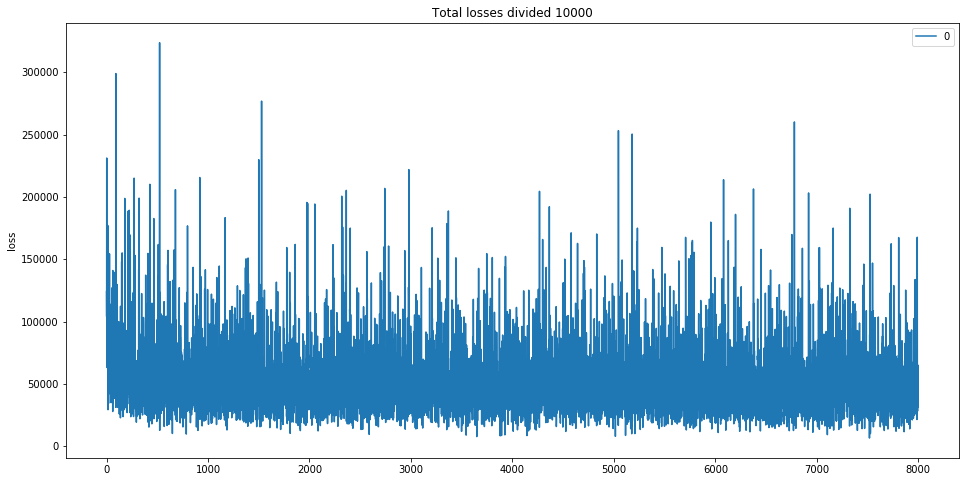

In [31]:
total_training_losses = pd.DataFrame(total_loss)

display_loss = total_training_losses[:].plot(title='Total losses divided 10000',figsize=(16,8))

display_loss.set_ylabel('loss')
display_loss.legend(loc='upper right')
plt.show()

In [32]:
inverse_net.save_weights("models/inverse_net_vgg19.h5")

In [34]:
test_content = encode_net.predict([content_image,style_image])


In [33]:
test_content.shape

(1, 64, 64, 256)

In [35]:
test_predict = output_image_func([test_content])

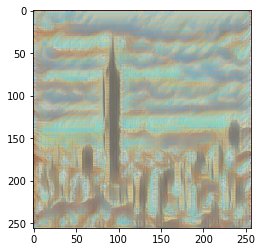

In [36]:
show_without_deprocess(test_predict[0])

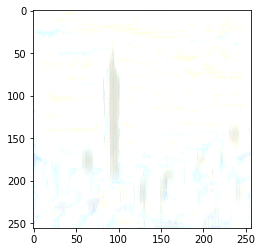

In [37]:
show(test_predict[0], save=False, name='test_1')

In [ ]:
tt[0].shape